% BARPA driver demo

BARPA (Bureau of Meteorology Atmospheric Regional Projections for Australia) is a dataset made of regional downscaling of CMIP6 historical and climate projection runs for the Australia/New Zealand region at a resolution around 17 km.
More information can be found on the NCI page to the dataset: https://opus.nci.org.au/pages/viewpage.action?pageId=264241161

The dataset focuses and atmosphere only. It has historical runs as well as runs for 3 climate projection scenarios (SSP126, SSP370 and SSP585). Except for the SSP585 scenario for which only 2 realisations are available, 7 realisations are available for all other scenarios with each realisation being forced by different models (source_id in CMIP6 vocabulary).

The data is available only as variables in 2 dimensions of spaces (sometimes multiple variables are available corresponding to different levels). The data is available for different time resolutions ranging from hourly to monthly. The data is published by the Australian Bureau of Meteorology under Creative Commons Attribution 4.0 International license and accessible via a thredds server.

The data is accessible for convenience in datamesh as virtual datacubes. Each datacube is defined for a single scenario and time resolution and contains all variables and sources/members available on the thredds server.

This notebook illustrates interactions with the datacubes via the datamesh python interface.

NB:
- IMPORTANT: 2 calendars (with and without leap days) are used accross the different model runs. In order to fit all models in the same datacubes, we had to align them all to a single calendar including leap days. Hence some of the models will have no data (nans) for all leap days. Depending on your use case, you might what to remove/account for those nans when using the data.
- We encourage users to favour the query interface to access the data as the datacubes are large and this will make for a much better user experience.
- Datasets can be spatially subsampled using a bounding box filter or point interpolation but we know that at present polygon based filtering is not working
- It is likely the datacubes can still be optimised and any feedback/bug report is welcome.

Let's get started with the demo and as always start by loading the necessary libraries.

In [58]:
import os, dotenv
from oceanum.datamesh import Connector, Query
from matplotlib import pyplot as plt

dotenv.load_dotenv("/home/sebastien/.env/.datamesh")

# For now the BARPA data is only available  on the Oceanum development platform so we point 
# the connector to the development server.
datamesh = Connector(service="https://datamesh.oceanum.tech",
                     token=os.getenv("OCEANUM_USER_IO_TOKEN"))

Here is a list of the available BARPA datasets. The id is self explanatory but it is always possible
do a get_datasource to get more information.

In [21]:
datamesh.get_catalog(["barpa"]).ids

['bom_barpa_ssp370_mon',
 'bom_barpa_ssp585_1hr',
 'bom_barpa_historical_1hr',
 'bom_barpa_ssp126_mon',
 'bom_barpa_ssp585_mon',
 'bom_barpa_ssp126_1hr',
 'bom_barpa_ssp370_1hr',
 'bom_barpa_historical_day',
 'bom_barpa_historical_mon',
 'bom_barpa_ssp585_day',
 'bom_barpa_ssp126_day',
 'bom_barpa_ssp370_day']

# Hourly data

For start, let's look at the historical hourly data

In [22]:
dsrc = datamesh.get_datasource("bom_barpa_historical_1hr")
dsrc


        BARPA historical hourly [bom_barpa_historical_1hr]
            Extent: (88.0355, -53.5755, 207.9275, 13.632)
            Timerange: 1960-01-01 01:00:00+00:00 to 2014-12-31 23:00:00+00:00
            62 attributes
            68 variables
        

Here are the 68 variables available in the dataset.
We could see the same thing in a prettier way using the load_datasource method, however, this method requires crawling through the BARPA thredds server and can take a while. Hence, it is recommended to look at the metadata and then use the query interface to interect with the data.

In [8]:
dsrc.variables

{'pr': {'dims': ['cube_member_id', 'time', 'lat', 'lon'],
  'attrs': {'units': 'kg m-2 s-1',
   'long_name': 'Precipitation',
   '_ChunkSizes': [82, 42, 76],
   'cell_methods': 'time: mean (interval: 1 hour)',
   'standard_name': 'precipitation_flux'},
  'dtype': 'float64',
  'shape': [7, 482135, 436, 777]},
 'ps': {'dims': ['cube_member_id', 'time', 'lat', 'lon'],
  'attrs': {'units': 'Pa',
   'long_name': 'Surface Air Pressure',
   '_ChunkSizes': [82, 42, 76],
   'cell_methods': 'time: point (interval: 1H)',
   'standard_name': 'surface_air_pressure'},
  'dtype': 'float64',
  'shape': [7, 482135, 436, 777]},
 'ts': {'dims': ['cube_member_id', 'time', 'lat', 'lon'],
  'attrs': {'units': 'K',
   'long_name': 'Surface Temperature',
   '_ChunkSizes': [82, 42, 76],
   'cell_methods': 'time: point (interval: 1H)',
   'standard_name': 'surface_temperature'},
  'dtype': 'float64',
  'shape': [7, 482135, 436, 777]},
 'CIN': {'dims': ['cube_member_id', 'time', 'lat', 'lon'],
  'attrs': {'units

For now let's retrieve a few days of data over a small rectangular area and limit ourselves to 3 variables. We don't filter by ensemble member yet. We can see that 7 model runs are available each corresponding to a different model of the CMIP6 cohort.

In [23]:
query = Query(**{"datasource": "bom_barpa_historical_1hr",
                 "timefilter": {"times": ["2010-01-01T00:00:00", "2010-01-03T00:00:00"]},
                 "variables": ["tas", "uas", "vas"],
                 "geofilter":{"type": "bbox", "geom": [88, -53, 108, -36]},
#                "coordfilter": [{"coord": "ensemble", "values": ["EC-Earth3_r1i1p1f1"]}]
     })
historical_data = datamesh.query(query, use_dask=True)
historical_data

<xarray.Dataset> Size: 118MB
Dimensions:         (cube_member_id: 7, lat: 110, lon: 130, time: 49)
Coordinates:
  * cube_member_id  (cube_member_id) <U30 840B 'ACCESS-CM2_r4i1p1f1' ... 'Nor...
  * lat             (lat) float64 880B -52.96 -52.8 -52.65 ... -36.27 -36.12
  * lon             (lon) float64 1kB 88.04 88.19 88.34 ... 107.7 107.8 108.0
  * time            (time) datetime64[ns] 392B 2010-01-01 ... 2010-01-03
Data variables:
    crs             int64 8B ...
    member_id       (cube_member_id) <U20 560B dask.array<chunksize=(7,), meta=np.ndarray>
    source_id       (cube_member_id) <U20 560B dask.array<chunksize=(7,), meta=np.ndarray>
    tas             (cube_member_id, time, lat, lon) float64 39MB dask.array<chunksize=(1, 49, 80, 130), meta=np.ndarray>
    uas             (cube_member_id, time, lat, lon) float64 39MB dask.array<chunksize=(1, 49, 80, 130), meta=np.ndarray>
    vas             (cube_member_id, time, lat, lon) float64 39MB dask.array<chunksize=(1, 49, 80, 130), meta=np.ndarray>

Details of the sources are stored in some of the variables and can be used for filtering. For example the id of the different sources and the member they correspond to is

In [43]:
historical_data.source_id.values

array(['ACCESS-CM2', 'ACCESS-ESM1-5', 'CESM2', 'CMCC-ESM2', 'EC-Earth3',
       'MPI-ESM1-2-HR', 'NorESM2-MM'], dtype='<U20')

In [24]:
historical_data.member_id.values

array(['r4i1p1f1', 'r6i1p1f1', 'r11i1p1f1', 'r1i1p1f1', 'r1i1p1f1',
       'r1i1p1f1', 'r1i1p1f1'], dtype='<U20')

As we are happy with the dataset, we now download it in memory.

In [33]:
historical_data.load()

<xarray.Dataset> Size: 118MB
Dimensions:         (cube_member_id: 7, lat: 110, lon: 130, time: 49)
Coordinates:
  * cube_member_id  (cube_member_id) <U30 840B 'ACCESS-CM2_r4i1p1f1' ... 'Nor...
  * lat             (lat) float64 880B -52.96 -52.8 -52.65 ... -36.27 -36.12
  * lon             (lon) float64 1kB 88.04 88.19 88.34 ... 107.7 107.8 108.0
  * time            (time) datetime64[ns] 392B 2010-01-01 ... 2010-01-03
Data variables:
    crs             int64 8B 0
    member_id       (cube_member_id) <U20 560B 'r4i1p1f1' ... 'r1i1p1f1'
    source_id       (cube_member_id) <U20 560B 'ACCESS-CM2' ... 'NorESM2-MM'
    tas             (cube_member_id, time, lat, lon) float64 39MB 277.8 ... 2...
    uas             (cube_member_id, time, lat, lon) float64 39MB 8.751 ... 6...
    vas             (cube_member_id, time, lat, lon) float64 39MB 6.385 ... 7...

We repeat the same process for the climate projection datasets. Notice that 7 model runs are available for ssp126 and ssp370, but only 2 for ssp585

In [25]:
query = Query(**{"datasource": "bom_barpa_ssp126_1hr",
                 "timefilter": {"times": ["2020-01-01T00:00:00", "2020-01-03T00:00:00"]},
                 "variables": ["tas", "uas", "vas"],
                 "geofilter":{"type": "bbox", "geom": [88, -53, 108, -36]},
     })
ssp126_data = datamesh.query(query, use_dask=True)
ssp126_data

<xarray.Dataset> Size: 118MB
Dimensions:         (cube_member_id: 7, lat: 110, lon: 130, time: 49)
Coordinates:
  * cube_member_id  (cube_member_id) <U30 840B 'ACCESS-CM2_r4i1p1f1' ... 'Nor...
  * lat             (lat) float64 880B -52.96 -52.8 -52.65 ... -36.27 -36.12
  * lon             (lon) float64 1kB 88.04 88.19 88.34 ... 107.7 107.8 108.0
  * time            (time) datetime64[ns] 392B 2020-01-01 ... 2020-01-03
Data variables:
    crs             int64 8B ...
    member_id       (cube_member_id) <U20 560B dask.array<chunksize=(7,), meta=np.ndarray>
    source_id       (cube_member_id) <U20 560B dask.array<chunksize=(7,), meta=np.ndarray>
    tas             (cube_member_id, time, lat, lon) float64 39MB dask.array<chunksize=(1, 49, 80, 130), meta=np.ndarray>
    uas             (cube_member_id, time, lat, lon) float64 39MB dask.array<chunksize=(1, 49, 80, 130), meta=np.ndarray>
    vas             (cube_member_id, time, lat, lon) float64 39MB dask.array<chunksize=(1, 49, 80, 130), meta=np.ndarray>

In [ ]:
ssp126_data.load()

In [31]:
query = Query(**{"datasource": "bom_barpa_ssp370_1hr",
                 "timefilter": {"times": ["2020-01-01T00:00:00", "2020-01-03T00:00:00"]},
                 "variables": ["tas", "uas", "vas"],
                 "geofilter":{"type": "bbox", "geom": [88, -53, 108, -36]},
#                "coordfilter": [{"coord": "ensemble", "values": ["EC-Earth3_r1i1p1f1"]}]
     })
ssp370_data = datamesh.query(query, use_dask=True)
ssp370_data

<xarray.Dataset> Size: 118MB
Dimensions:         (cube_member_id: 7, lat: 110, lon: 130, time: 49)
Coordinates:
  * cube_member_id  (cube_member_id) <U30 840B 'ACCESS-CM2_r4i1p1f1' ... 'Nor...
  * lat             (lat) float64 880B -52.96 -52.8 -52.65 ... -36.27 -36.12
  * lon             (lon) float64 1kB 88.04 88.19 88.34 ... 107.7 107.8 108.0
  * time            (time) datetime64[ns] 392B 2020-01-01 ... 2020-01-03
Data variables:
    crs             int64 8B ...
    member_id       (cube_member_id) <U20 560B dask.array<chunksize=(7,), meta=np.ndarray>
    source_id       (cube_member_id) <U20 560B dask.array<chunksize=(7,), meta=np.ndarray>
    tas             (cube_member_id, time, lat, lon) float64 39MB dask.array<chunksize=(1, 49, 80, 130), meta=np.ndarray>
    uas             (cube_member_id, time, lat, lon) float64 39MB dask.array<chunksize=(1, 49, 80, 130), meta=np.ndarray>
    vas             (cube_member_id, time, lat, lon) float64 39MB dask.array<chunksize=(1, 49, 80, 130), meta=np.ndarray>

In [34]:
ssp370_data.load()

<xarray.Dataset> Size: 118MB
Dimensions:         (cube_member_id: 7, lat: 110, lon: 130, time: 49)
Coordinates:
  * cube_member_id  (cube_member_id) <U30 840B 'ACCESS-CM2_r4i1p1f1' ... 'Nor...
  * lat             (lat) float64 880B -52.96 -52.8 -52.65 ... -36.27 -36.12
  * lon             (lon) float64 1kB 88.04 88.19 88.34 ... 107.7 107.8 108.0
  * time            (time) datetime64[ns] 392B 2020-01-01 ... 2020-01-03
Data variables:
    crs             int64 8B 0
    member_id       (cube_member_id) <U20 560B 'r4i1p1f1' ... 'r1i1p1f1'
    source_id       (cube_member_id) <U20 560B 'ACCESS-CM2' ... 'NorESM2-MM'
    tas             (cube_member_id, time, lat, lon) float64 39MB 279.3 ... 2...
    uas             (cube_member_id, time, lat, lon) float64 39MB 5.831 ... 4...
    vas             (cube_member_id, time, lat, lon) float64 39MB -6.254 ... ...

In [32]:
query = Query(**{"datasource": "bom_barpa_ssp585_1hr",
                 "timefilter": {"times": ["2020-01-01T00:00:00", "2020-01-03T00:00:00"]},
                 "variables": ["tas", "uas", "vas"],
                 "geofilter":{"type": "bbox", "geom": [88, -53, 108, -36]},
#                "coordfilter": [{"coord": "ensemble", "values": ["EC-Earth3_r1i1p1f1"]}]
     })
ssp585_data = datamesh.query(query, use_dask=True)
ssp585_data

<xarray.Dataset> Size: 34MB
Dimensions:         (cube_member_id: 2, lat: 110, lon: 130, time: 49)
Coordinates:
  * cube_member_id  (cube_member_id) <U30 240B 'ACCESS-CM2_r4i1p1f1' 'EC-Eart...
  * lat             (lat) float64 880B -52.96 -52.8 -52.65 ... -36.27 -36.12
  * lon             (lon) float64 1kB 88.04 88.19 88.34 ... 107.7 107.8 108.0
  * time            (time) datetime64[ns] 392B 2020-01-01 ... 2020-01-03
Data variables:
    crs             int64 8B ...
    member_id       (cube_member_id) <U20 160B dask.array<chunksize=(2,), meta=np.ndarray>
    source_id       (cube_member_id) <U20 160B dask.array<chunksize=(2,), meta=np.ndarray>
    tas             (cube_member_id, time, lat, lon) float64 11MB dask.array<chunksize=(1, 49, 80, 130), meta=np.ndarray>
    uas             (cube_member_id, time, lat, lon) float64 11MB dask.array<chunksize=(1, 49, 80, 130), meta=np.ndarray>
    vas             (cube_member_id, time, lat, lon) float64 11MB dask.array<chunksize=(1, 49, 80, 130), meta=np.ndarray>

In [35]:
ssp585_data.load()

<xarray.Dataset> Size: 34MB
Dimensions:         (cube_member_id: 2, lat: 110, lon: 130, time: 49)
Coordinates:
  * cube_member_id  (cube_member_id) <U30 240B 'ACCESS-CM2_r4i1p1f1' 'EC-Eart...
  * lat             (lat) float64 880B -52.96 -52.8 -52.65 ... -36.27 -36.12
  * lon             (lon) float64 1kB 88.04 88.19 88.34 ... 107.7 107.8 108.0
  * time            (time) datetime64[ns] 392B 2020-01-01 ... 2020-01-03
Data variables:
    crs             int64 8B 0
    member_id       (cube_member_id) <U20 160B 'r4i1p1f1' 'r1i1p1f1'
    source_id       (cube_member_id) <U20 160B 'ACCESS-CM2' 'EC-Earth3'
    tas             (cube_member_id, time, lat, lon) float64 11MB 277.9 ... 2...
    uas             (cube_member_id, time, lat, lon) float64 11MB 9.654 ... 3...
    vas             (cube_member_id, time, lat, lon) float64 11MB 4.061 ... 0...

Now to make sure that we have really downloaded data, for each of the datasets we do a spatial plot of the last time step downloaded for one of the variables selected at random. We then do a time series plot at a given location.

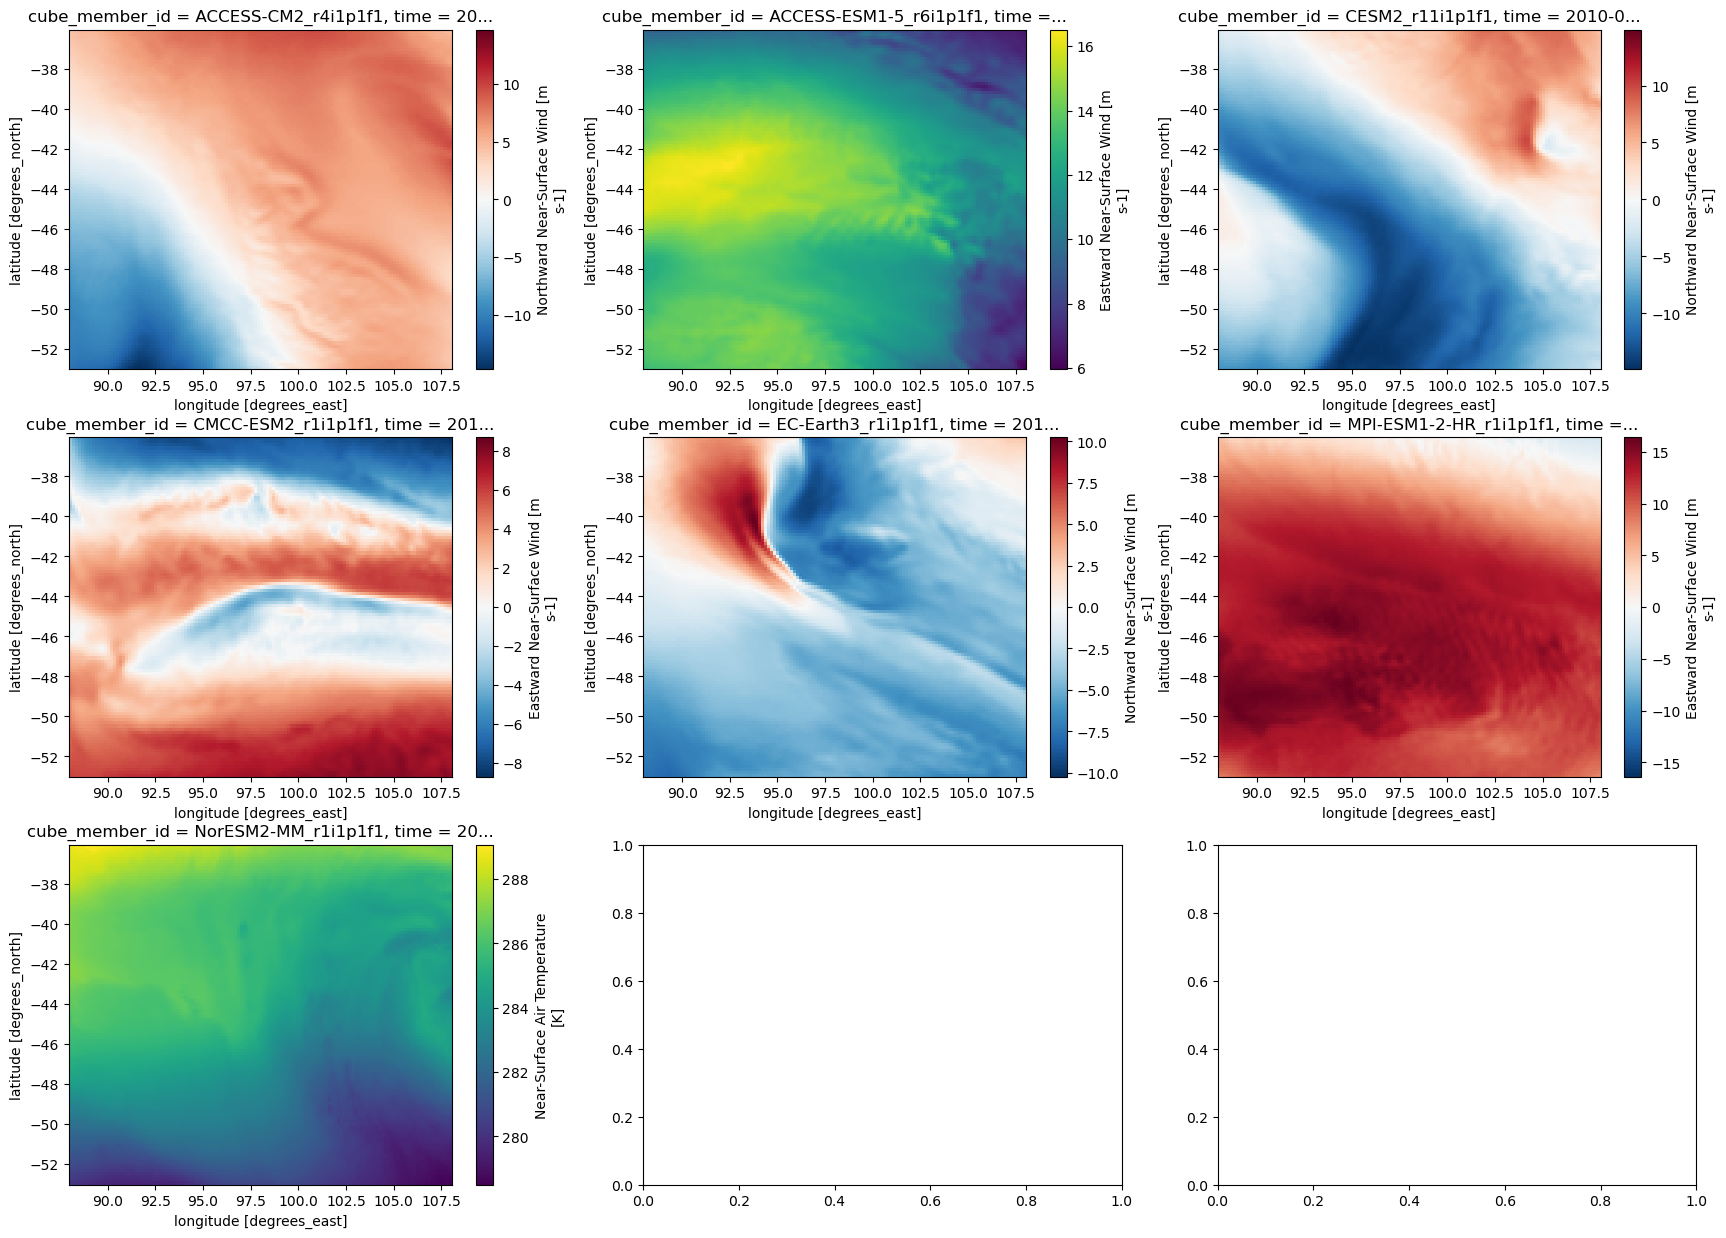

In [38]:
from matplotlib import pyplot as plt
import numpy as np

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(21, 15))
ax = ax.flatten()
for i in range(historical_data.cube_member_id.size):
    historical_data[np.random.choice(['uas', 'vas', 'tas'])].isel(time=-1, cube_member_id=i).plot(ax=ax[i])

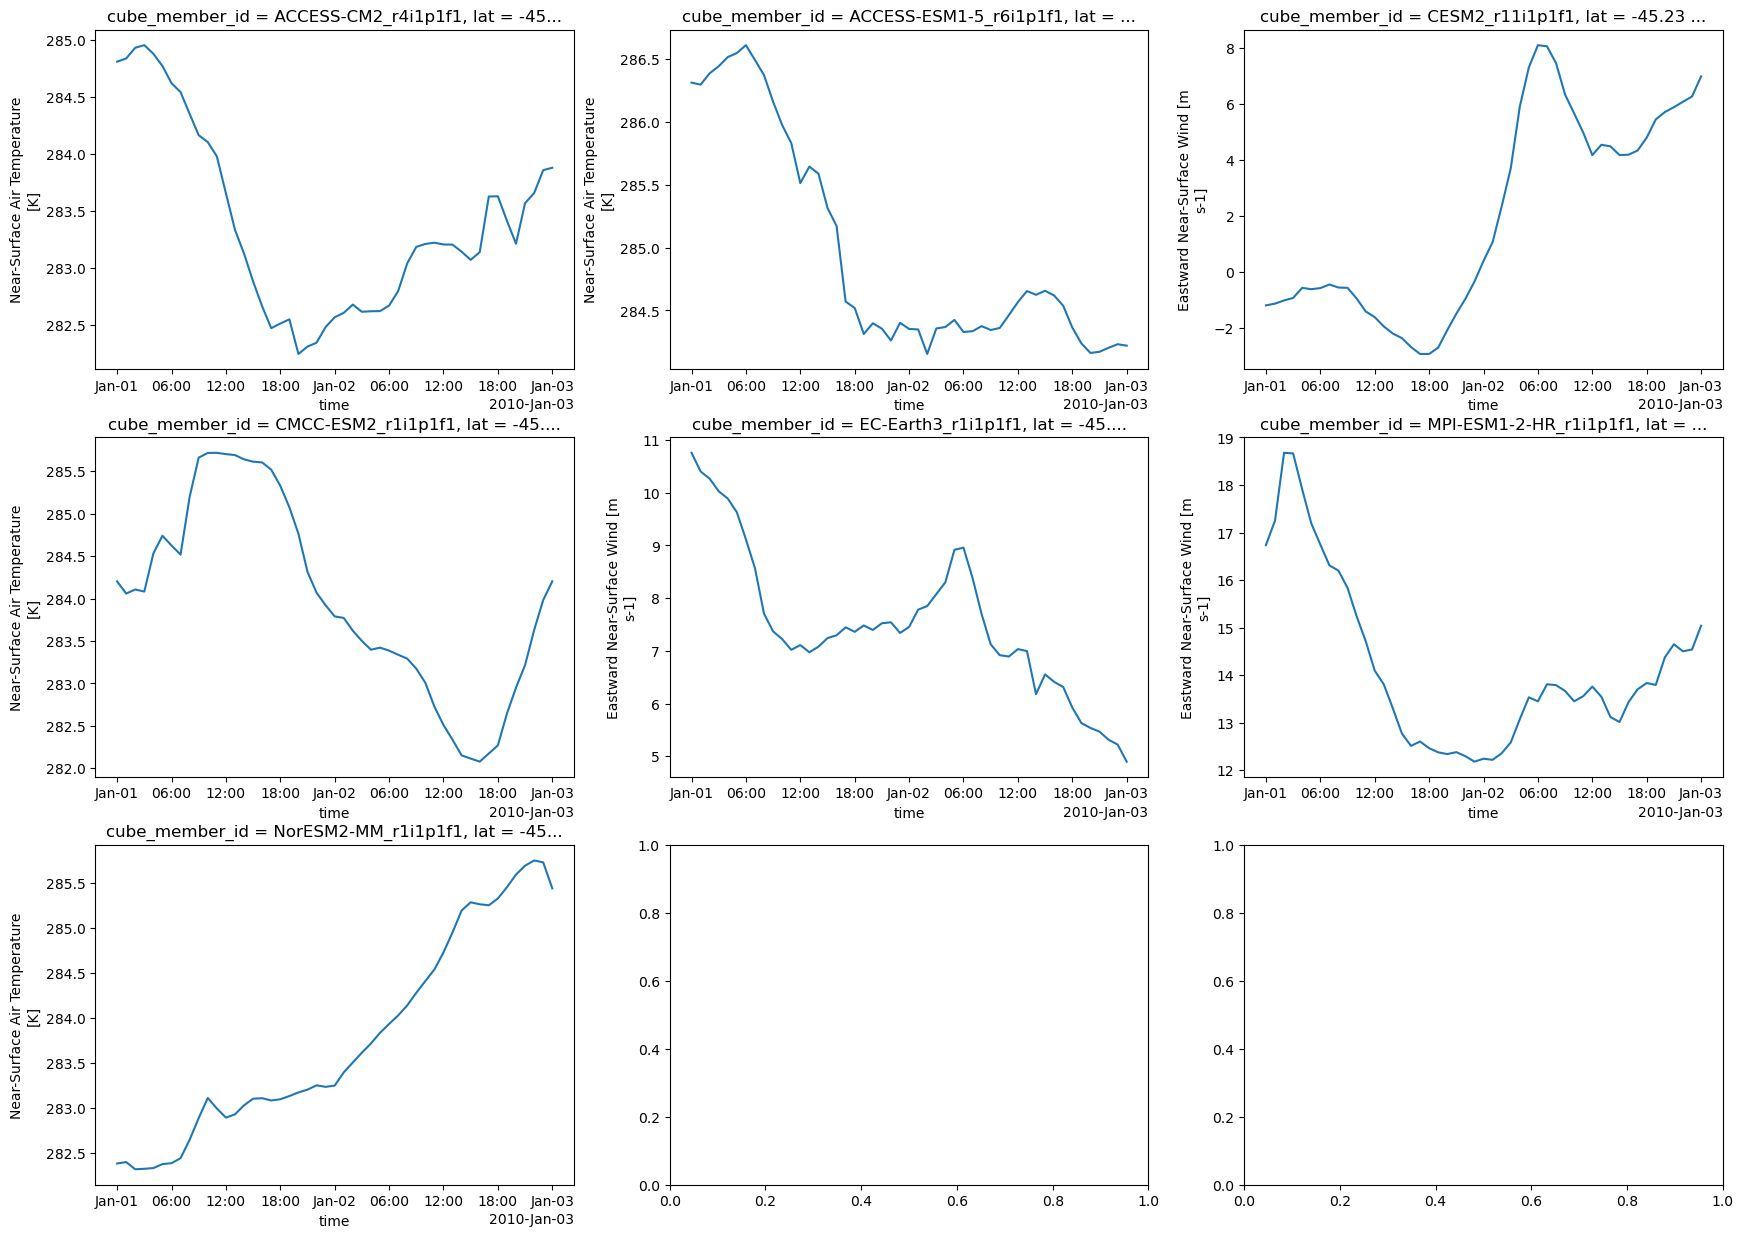

In [39]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(21, 15))
ax = ax.flatten()
for i in range(historical_data.cube_member_id.size):
    historical_data[np.random.choice(['uas', 'vas', 'tas'])].isel(lat=50,lon=50, cube_member_id=i).plot(ax=ax[i])

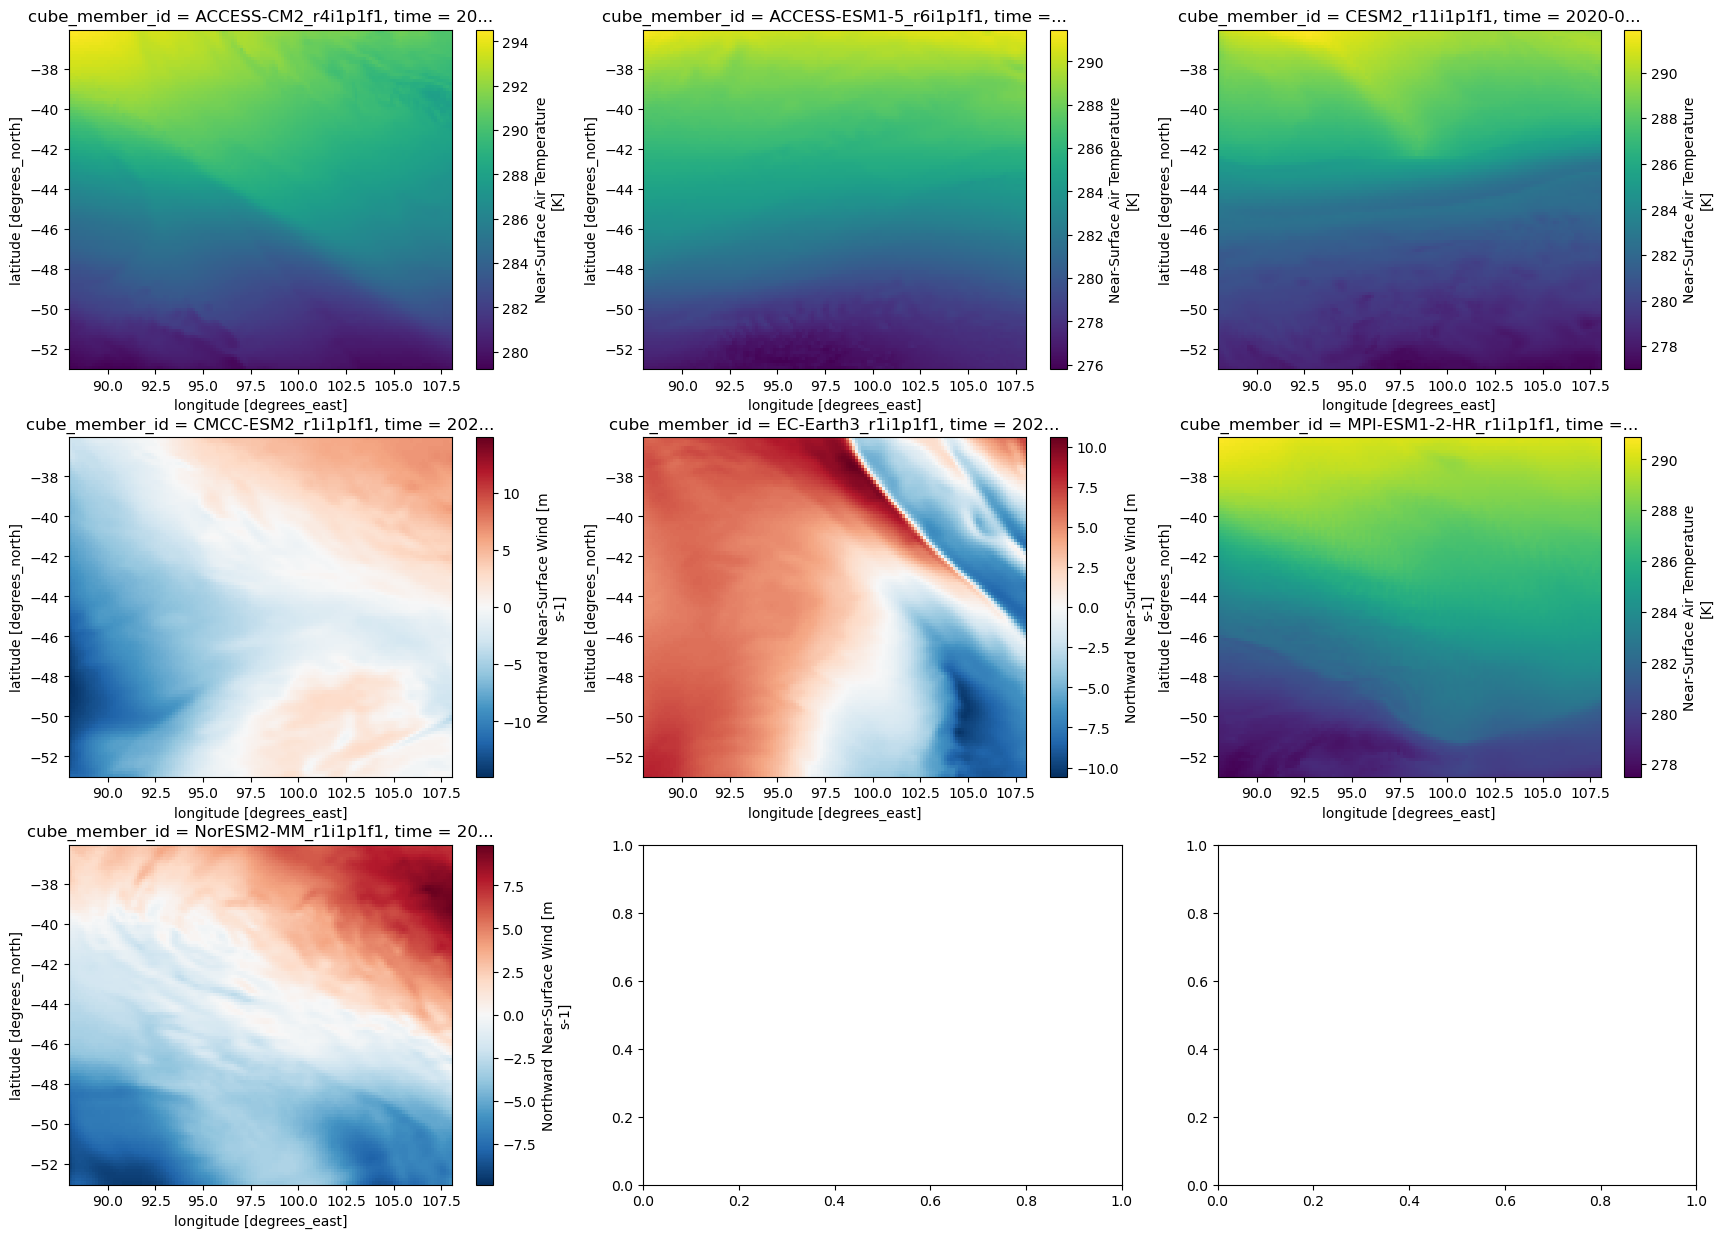

In [28]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(21, 15))
ax = ax.flatten()
for i in range(ssp126_data.cube_member_id.size):
    ssp126_data[np.random.choice(['uas', 'vas', 'tas'])].isel(time=-1, cube_member_id=i).plot(ax=ax[i])

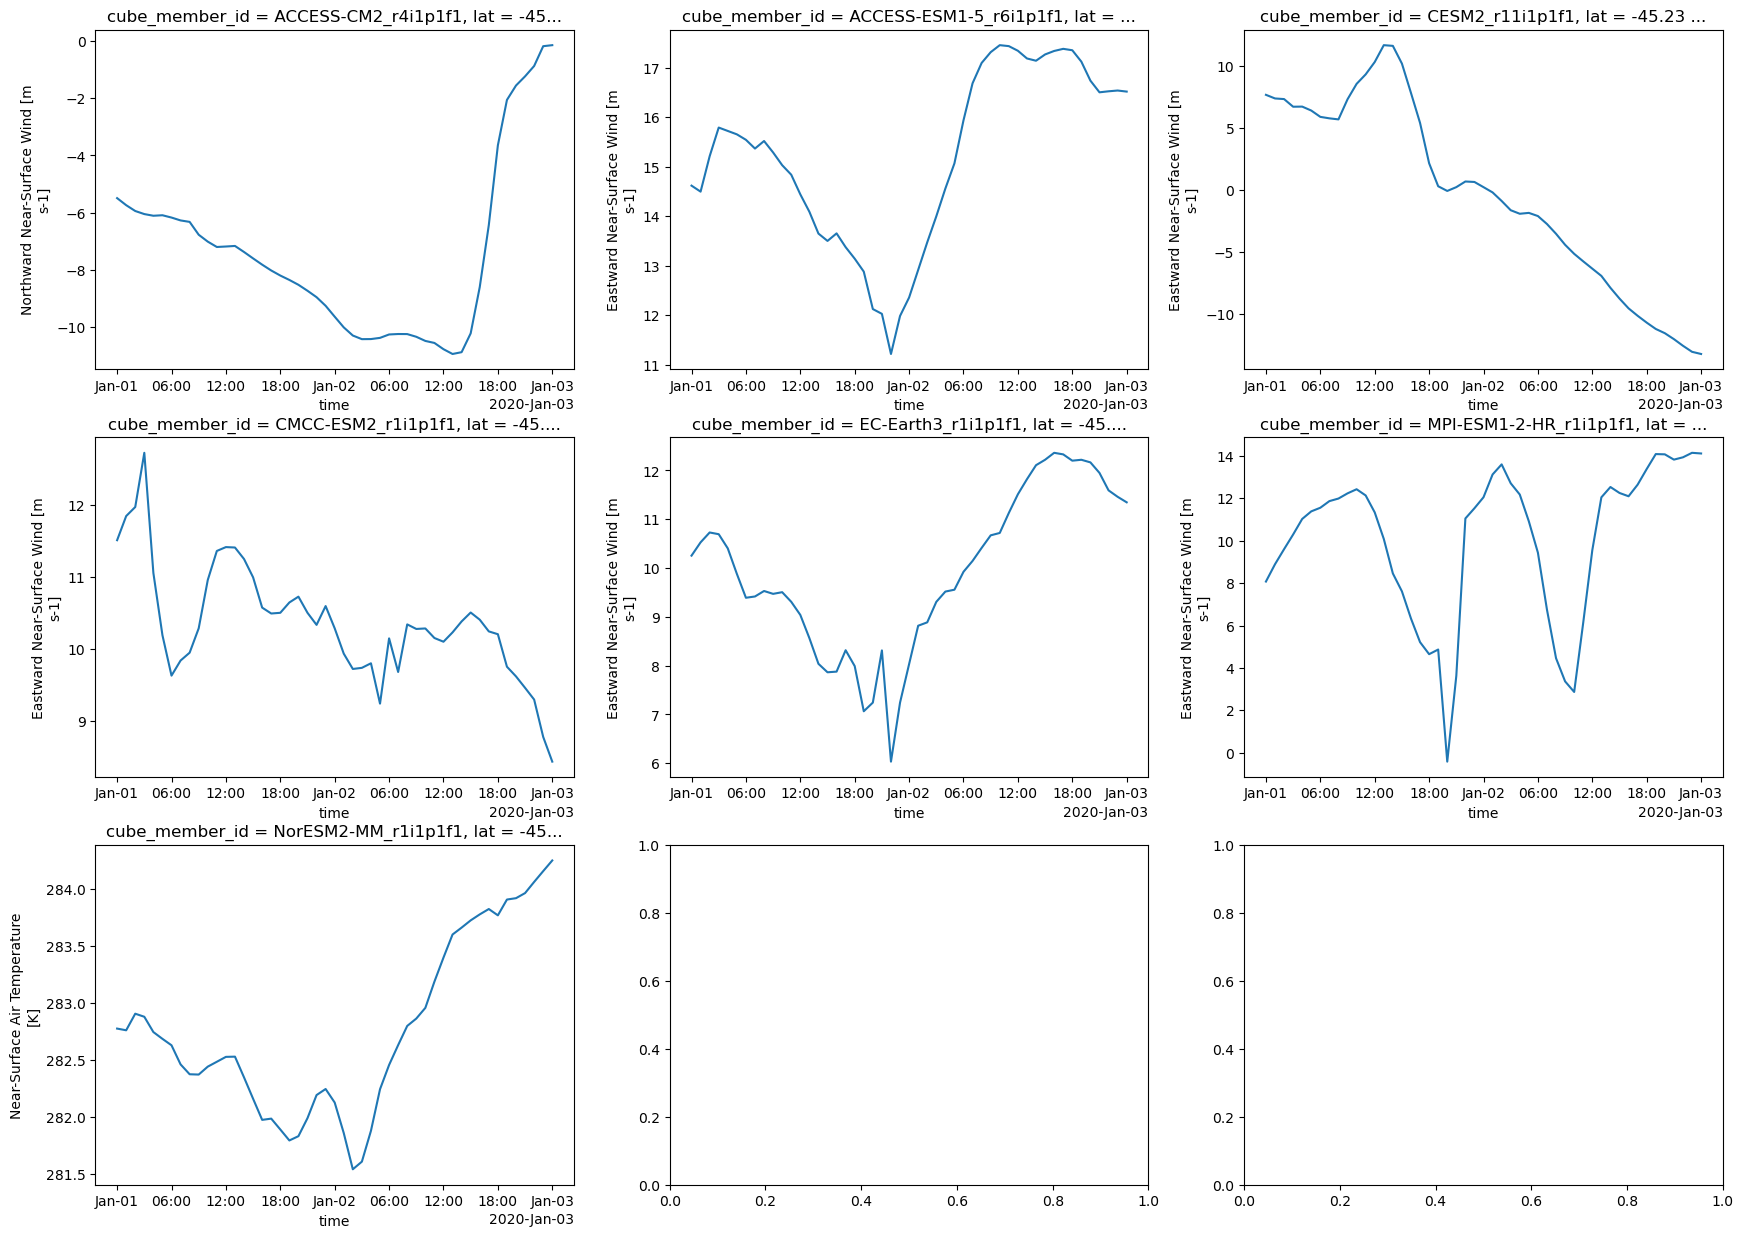

In [40]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(21, 15))
ax = ax.flatten()
for i in range(ssp126_data.cube_member_id.size):
    ssp126_data[np.random.choice(['uas', 'vas', 'tas'])].isel(lat=50,lon=50, cube_member_id=i).plot(ax=ax[i])

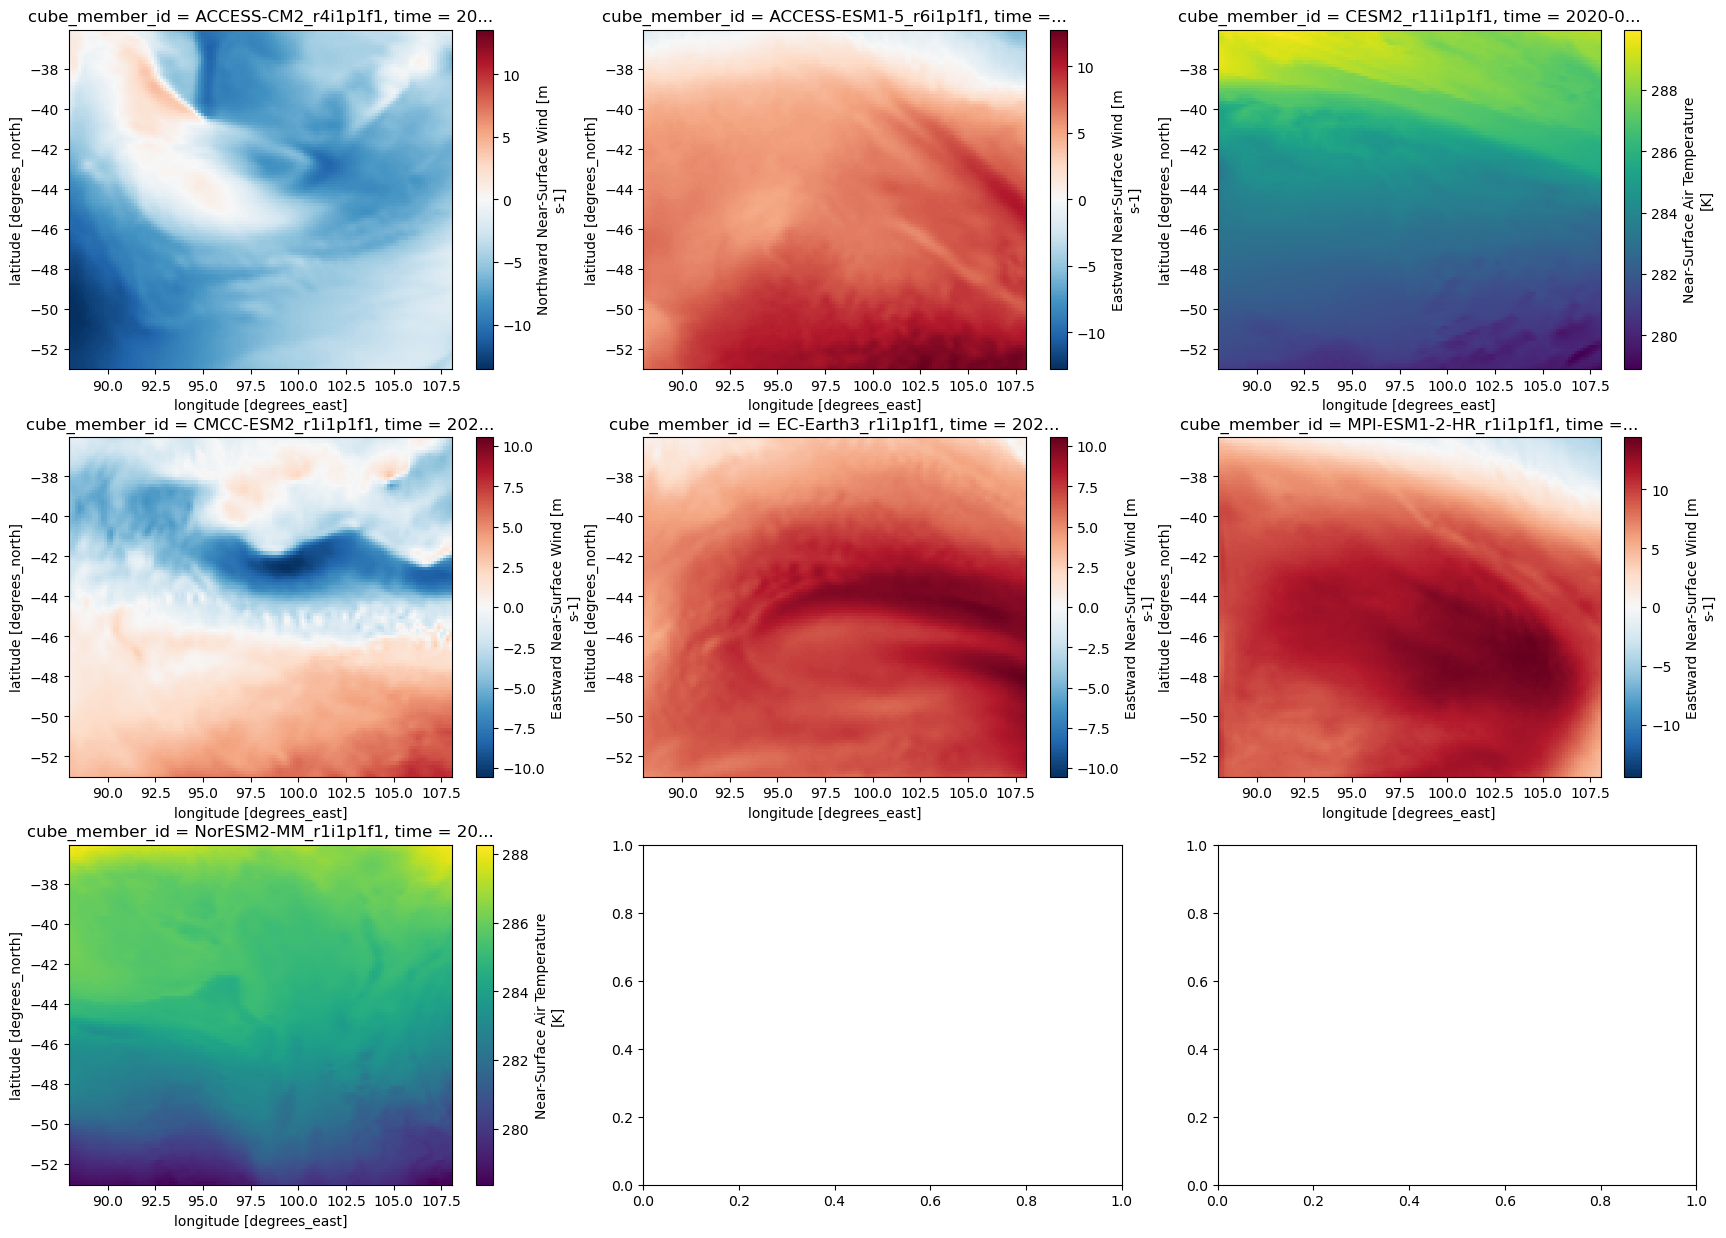

In [36]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(21, 15))
ax = ax.flatten()
for i in range(ssp370_data.cube_member_id.size):
    ssp370_data[np.random.choice(['uas', 'vas', 'tas'])].isel(time=-1, cube_member_id=i).plot(ax=ax[i])

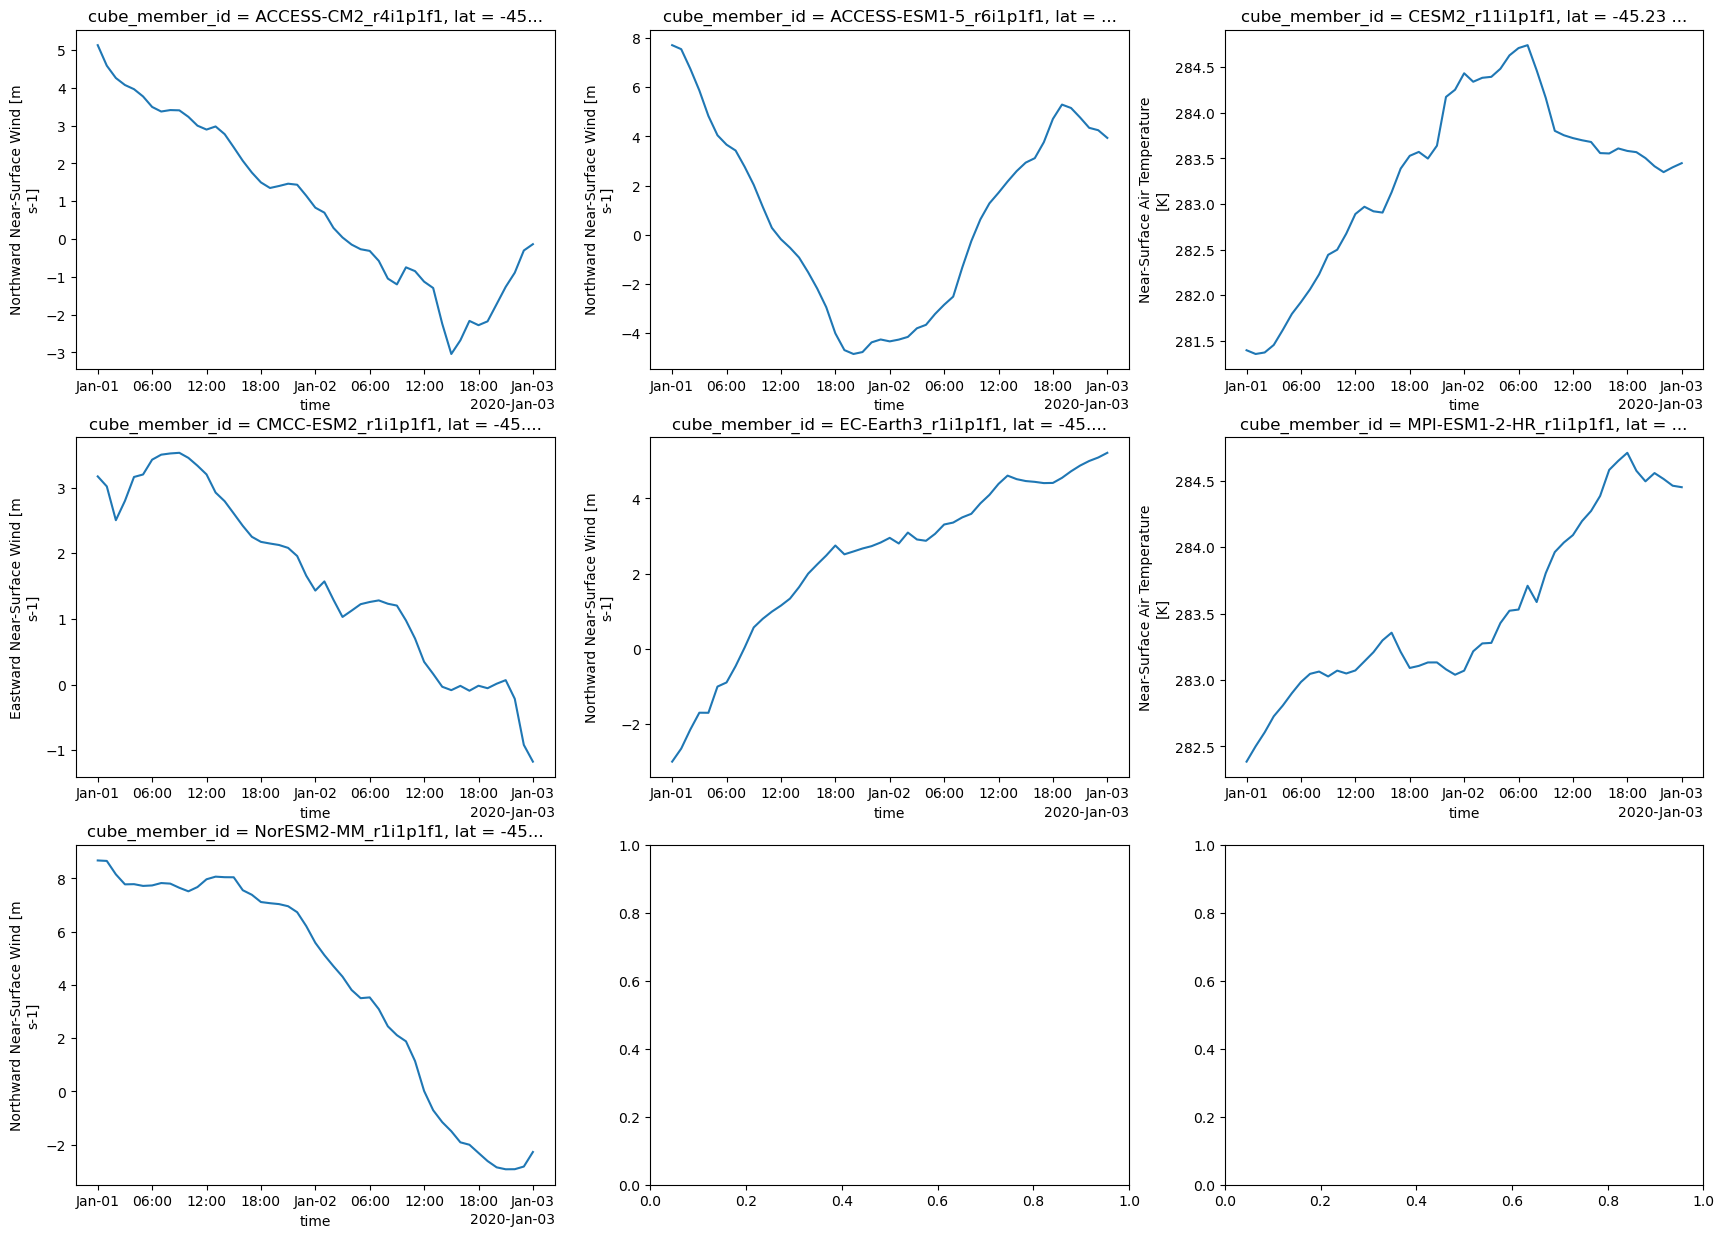

In [41]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(21, 15))
ax = ax.flatten()
for i in range(ssp370_data.cube_member_id.size):
    ssp370_data[np.random.choice(['uas', 'vas', 'tas'])].isel(lat=50,lon=50, cube_member_id=i).plot(ax=ax[i])

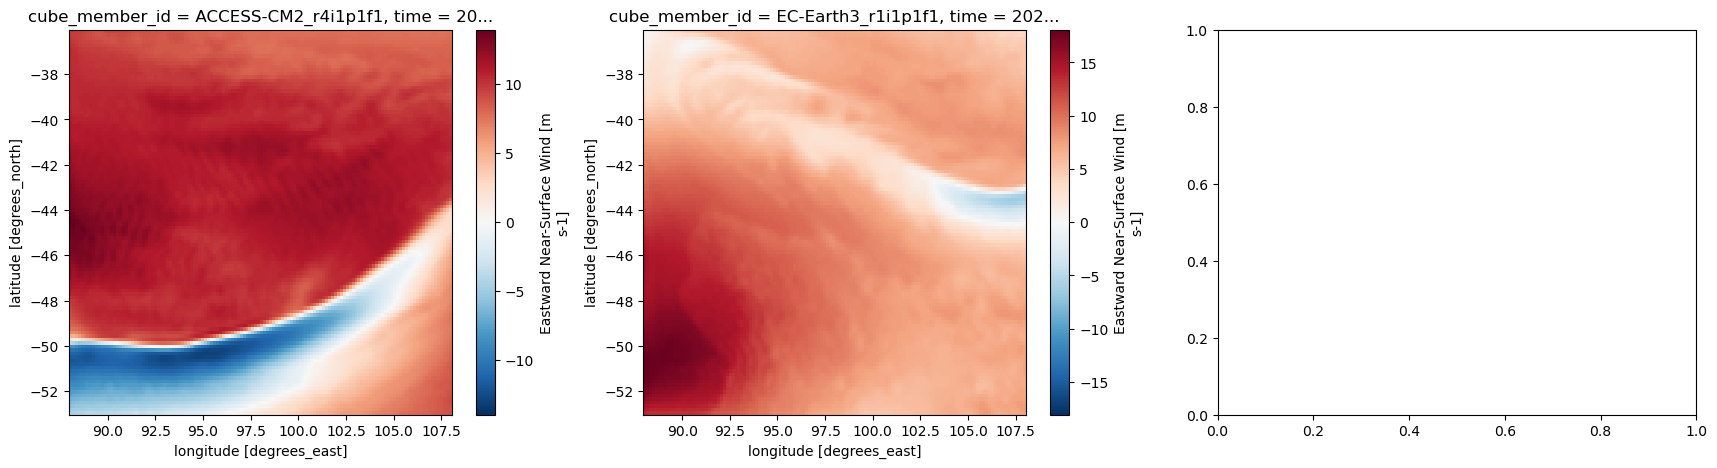

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(21, 5))
ax = ax.flatten()
for i in range(ssp585_data.cube_member_id.size):
    ssp585_data[np.random.choice(['uas', 'vas', 'tas'])].isel(time=-1, cube_member_id=i).plot(ax=ax[i])

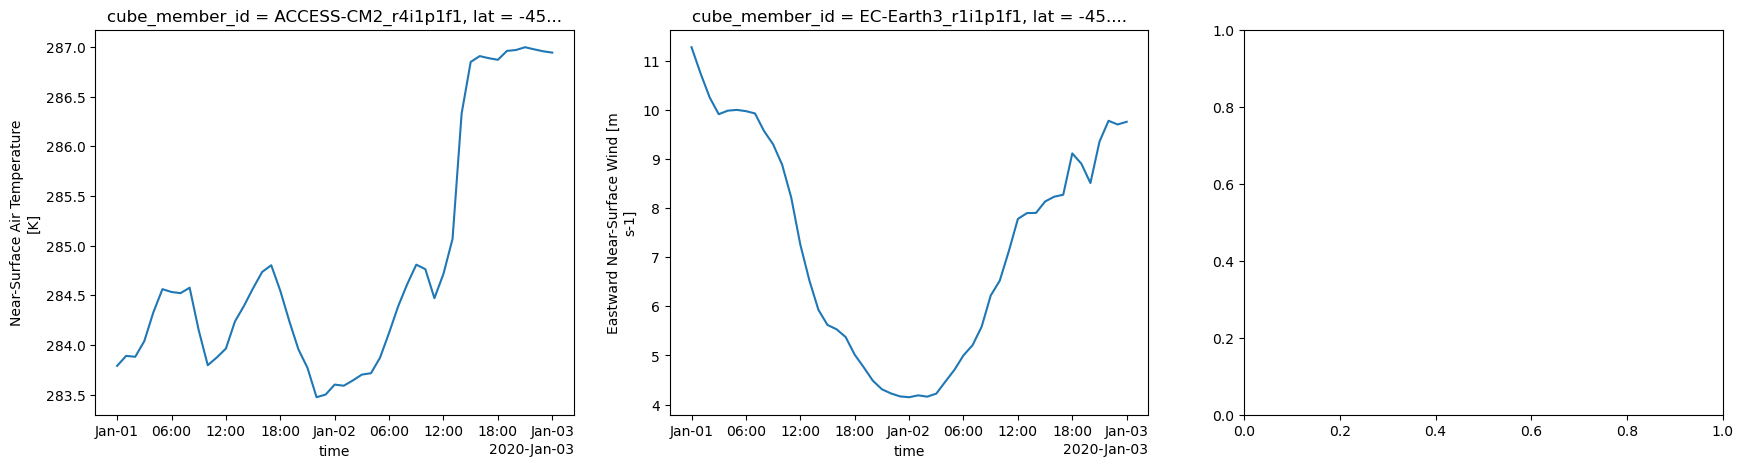

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(21, 5))
ax = ax.flatten()
for i in range(ssp585_data.cube_member_id.size):
    ssp585_data[np.random.choice(['uas', 'vas', 'tas'])].isel(lat=50,lon=50, cube_member_id=i).plot(ax=ax[i])

# Monthly data

There is nothing special about accessing the monthly data but for illustration purposes (and to make sure the datacubes work), we will access the montly data interpolated at a single point location.
Let's start with the historical data for which we only ask for suface temperature data for one of the ensemble members.

In [27]:
import shapely
historical_data_mon = datamesh.query(Query(datasource="bom_barpa_historical_mon",
                                            variables=["tas"],
                             timefilter={"times": ["1960-01-01T00:00:00", "1966-01-01T00:00:00"]},
                             coordfilter= [{"coord": "cube_member_id", "values": ['ACCESS-CM2_r4i1p1f1']}],
                             geofilter={"type": "feature", "geom": shapely.geometry.Point(89, -50)}
                             ), use_dask=True)
historical_data_mon

<xarray.Dataset> Size: 1kB
Dimensions:         (cube_member_id: 1, time: 72)
Coordinates:
  * cube_member_id  (cube_member_id) <U30 120B 'ACCESS-CM2_r4i1p1f1'
  * time            (time) datetime64[ns] 576B 1960-01-16T12:00:00 ... 1965-1...
Data variables:
    crs             int64 8B ...
    lat             float64 8B ...
    lon             float64 8B ...
    member_id       (cube_member_id) <U20 80B dask.array<chunksize=(1,), meta=np.ndarray>
    source_id       (cube_member_id) <U20 80B dask.array<chunksize=(1,), meta=np.ndarray>
    tas             (cube_member_id, time) float64 576B dask.array<chunksize=(1, 72), meta=np.ndarray>

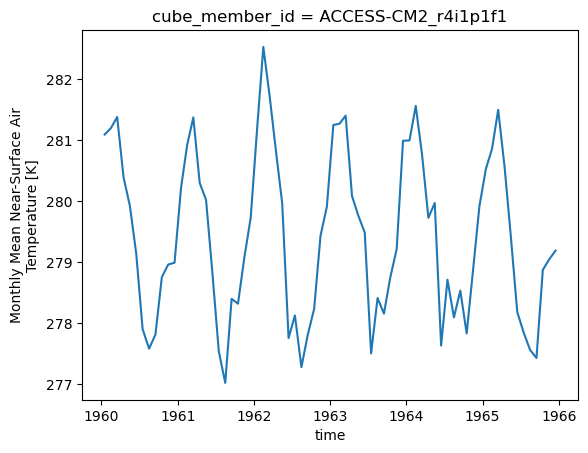

In [28]:
historical_data_mon.tas.plot()

For the climate scenario we will try to create a slightly more interesting plot. For that we download 20 years of surface temperature interpolated to a single point location for all ensemble members available.
Unless the data is already cached in datamesh, this will take some time to download.

In [59]:
ssp126_data_mon = datamesh.query(Query(datasource="bom_barpa_ssp126_mon",
                                            variables=["tas"],
                             timefilter={"times": ["2020-01-01T00:00:00", "2040-01-01T00:00:00"]},
                             geofilter={"type": "feature", "geom": shapely.geometry.Point(89, -50)}
                             ), use_dask=True)
ssp126_data_mon.load()

<xarray.Dataset> Size: 17kB
Dimensions:         (cube_member_id: 7, time: 240)
Coordinates:
  * cube_member_id  (cube_member_id) <U30 840B 'ACCESS-CM2_r4i1p1f1' ... 'Nor...
  * time            (time) datetime64[ns] 2kB 2020-01-16T12:00:00 ... 2039-12...
Data variables:
    crs             int64 8B 0
    lat             float64 8B -50.0
    lon             float64 8B 89.0
    member_id       (cube_member_id) <U20 560B 'r4i1p1f1' ... 'r1i1p1f1'
    source_id       (cube_member_id) <U20 560B 'ACCESS-CM2' ... 'NorESM2-MM'
    tas             (cube_member_id, time) float64 13kB 281.6 282.1 ... 281.0

In [62]:
ssp370_data_mon = datamesh.query(Query(datasource="bom_barpa_ssp370_mon",
                                            variables=["tas"],
                             timefilter={"times": ["2020-01-01T00:00:00", "2040-01-01T00:00:00"]},
                             geofilter={"type": "feature", "geom": shapely.geometry.Point(89, -50)}
                             ), use_dask=True)
ssp370_data_mon.load()

<xarray.Dataset> Size: 17kB
Dimensions:         (cube_member_id: 7, time: 240)
Coordinates:
  * cube_member_id  (cube_member_id) <U30 840B 'ACCESS-CM2_r4i1p1f1' ... 'Nor...
  * time            (time) datetime64[ns] 2kB 2020-01-16T12:00:00 ... 2039-12...
Data variables:
    crs             int64 8B 0
    lat             float64 8B -50.0
    lon             float64 8B 89.0
    member_id       (cube_member_id) <U20 560B 'r4i1p1f1' ... 'r1i1p1f1'
    source_id       (cube_member_id) <U20 560B 'ACCESS-CM2' ... 'NorESM2-MM'
    tas             (cube_member_id, time) float64 13kB 282.5 282.7 ... 280.5

In [63]:
ssp585_data_mon = datamesh.query(Query(datasource="bom_barpa_ssp585_mon",
                                            variables=["tas"],
                             timefilter={"times": ["2020-01-01T00:00:00", "2040-01-01T00:00:00"]},
                             geofilter={"type": "feature", "geom": shapely.geometry.Point(89, -50)}
                             ), use_dask=True)
ssp585_data_mon.load()

<xarray.Dataset> Size: 6kB
Dimensions:         (cube_member_id: 2, time: 240)
Coordinates:
  * cube_member_id  (cube_member_id) <U30 240B 'ACCESS-CM2_r4i1p1f1' 'EC-Eart...
  * time            (time) datetime64[ns] 2kB 2020-01-16T12:00:00 ... 2039-12...
Data variables:
    crs             int64 8B 0
    lat             float64 8B -50.0
    lon             float64 8B 89.0
    member_id       (cube_member_id) <U20 160B 'r4i1p1f1' 'r1i1p1f1'
    source_id       (cube_member_id) <U20 160B 'ACCESS-CM2' 'EC-Earth3'
    tas             (cube_member_id, time) float64 4kB 282.1 282.0 ... 282.6

In [ ]:
We plot the ensemble mean for each projection scenario.

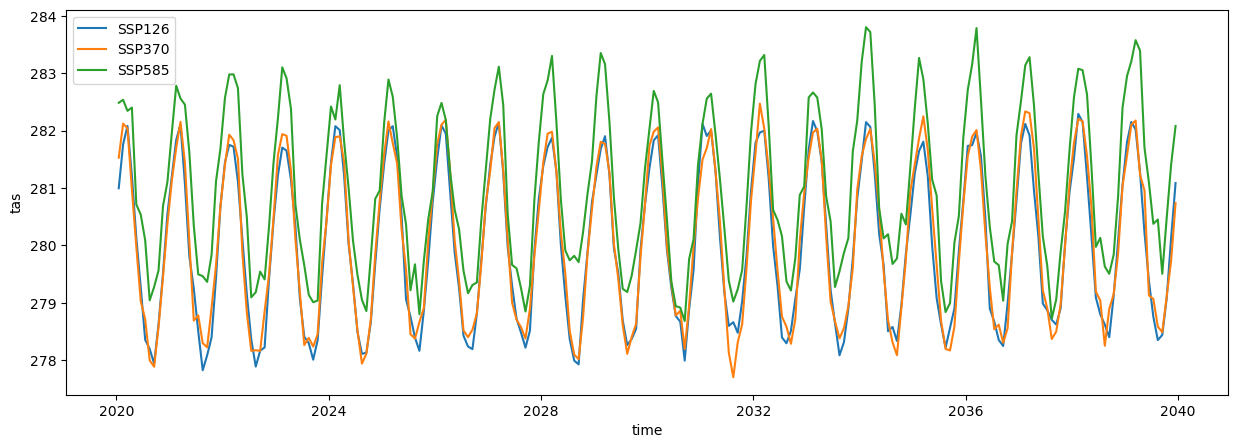

In [82]:
plt.figure(figsize=(15, 5))

ssp126_data_mon.tas.mean(dim="cube_member_id").plot()
ssp370_data_mon.tas.mean(dim="cube_member_id").plot()
ssp585_data_mon.tas.mean(dim="cube_member_id").plot()
plt.legend(["SSP126", "SSP370", "SSP585"])

In [ ]:
for i in range(ssp126_data_mon.cube_member_id.size):
    ssp126_data_mon.tas.isel(cube_member_id=i).plot(color='blue')
for i in range(ssp370_data_mon.cube_member_id.size):
    ssp370_data_mon.tas.isel(cube_member_id=i).plot(color='orange')
for i in range(ssp585_data_mon.cube_member_id.size):
    ssp585_data_mon.tas.isel(cube_member_id=i).plot(color='red')

# Calendars and NAN data 

As explained in the introduction, 2 calendars (with and without leap days) are used accross the different model runs. In order to fit all models in the same datacubes, we had to align them all to a single calendar including leap days. Hence some of the models will have no data (nans) for all leap days. Depending on your use case, you might what to remove/account for those nans when using the data.

Here we give a  quick illustration of the issue by downloading hourly surface temparature data interpolated at a single point location for the time period range from the 27th of February to the the 2nd of March 2020 (which is a leap year).

In [64]:
ssp126_data_cal = datamesh.query(Query(datasource="bom_barpa_ssp126_1hr",
                                            variables=["tas"],
                             timefilter={"times": ["2020-02-27T00:00:00", "2020-03-02T00:00:00"]},
                             geofilter={"type": "feature", "geom": shapely.geometry.Point(89, -50)}
                             ), use_dask=True)
ssp126_data_cal.load()

<xarray.Dataset> Size: 8kB
Dimensions:         (cube_member_id: 7, time: 97)
Coordinates:
  * cube_member_id  (cube_member_id) <U30 840B 'ACCESS-CM2_r4i1p1f1' ... 'Nor...
  * time            (time) datetime64[ns] 776B 2020-02-27 ... 2020-03-02
Data variables:
    crs             int64 8B 0
    lat             float64 8B -50.0
    lon             float64 8B 89.0
    member_id       (cube_member_id) <U20 560B 'r4i1p1f1' ... 'r1i1p1f1'
    source_id       (cube_member_id) <U20 560B 'ACCESS-CM2' ... 'NorESM2-MM'
    tas             (cube_member_id, time) float64 5kB 282.9 282.5 ... 282.6

Now plotting the data, we can see that some of the runs have no data at all for the 29th of February.

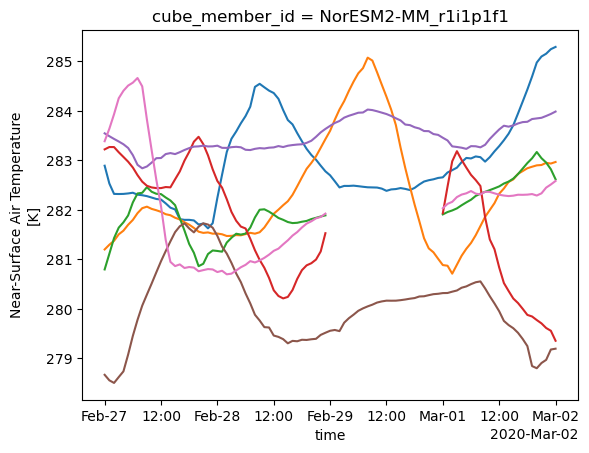

In [65]:
for i in range(ssp126_data_cal.cube_member_id.size):
    ssp126_data_cal.tas.isel(cube_member_id=i).plot()

For those runs, it is easy to remove the nans using the dropna method as shown below. That way we recover continuous data.


In [72]:
ssp126_data_cal.tas.isel(cube_member_id=2).values

array([280.79742269, 281.11314684, 281.42969308, 281.64153166,
       281.74878108, 281.88800025, 282.14979525, 282.33145111,
       282.344687  , 282.45843482, 282.36623702, 282.32501096,
       282.31822536, 282.2500472 , 282.18960137, 282.0950117 ,
       281.83436922, 281.58165537, 281.31099244, 281.1337567 ,
       280.86332824, 280.91186543, 281.10830318, 281.18055976,
       281.17033926, 281.15620295, 281.34052598, 281.43635275,
       281.51849865, 281.50118137, 281.52090111, 281.6412245 ,
       281.84743049, 282.00287862, 282.01171516, 281.96435339,
       281.90338939, 281.83713613, 281.79961196, 281.75462146,
       281.73344898, 281.73936858, 281.76074097, 281.77660732,
       281.81371334, 281.83946271, 281.86644063, 281.88938553,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,       

In [73]:
ssp126_data_cal.tas.isel(cube_member_id=2).dropna(dim="time").values

array([280.79742269, 281.11314684, 281.42969308, 281.64153166,
       281.74878108, 281.88800025, 282.14979525, 282.33145111,
       282.344687  , 282.45843482, 282.36623702, 282.32501096,
       282.31822536, 282.2500472 , 282.18960137, 282.0950117 ,
       281.83436922, 281.58165537, 281.31099244, 281.1337567 ,
       280.86332824, 280.91186543, 281.10830318, 281.18055976,
       281.17033926, 281.15620295, 281.34052598, 281.43635275,
       281.51849865, 281.50118137, 281.52090111, 281.6412245 ,
       281.84743049, 282.00287862, 282.01171516, 281.96435339,
       281.90338939, 281.83713613, 281.79961196, 281.75462146,
       281.73344898, 281.73936858, 281.76074097, 281.77660732,
       281.81371334, 281.83946271, 281.86644063, 281.88938553,
       281.90864224, 281.95621123, 281.98843161, 282.03017374,
       282.09334781, 282.15115131, 282.20498325, 282.28159645,
       282.32683531, 282.36402581, 282.3993026 , 282.43558528,
       282.47403674, 282.53191002, 282.57058818, 282.63